In [1]:
from pydataxm import *                           #Se realiza la importación de las librerias necesarias para ejecutar                        
from pydataxm.pydataxm import ReadDB as apiXM 
import datetime as dt                            
import pandas as pd
from pathlib import Path
import os

from google.cloud import bigquery
from google.oauth2 import service_account

In [2]:
# Información del proyecto y autenticación a BQ
project_id = "enersinc-tbsg-bq"
key_path = "C:\BigQuery\eramirez-tbsg.json"

# Cargar las credenciales del archivo JSON
credentials = service_account.Credentials.from_service_account_file(key_path)

# Crear el cliente de BigQuery
client = bigquery.Client(project=project_id, credentials=credentials)

In [3]:
FechaIni='2023-01-01'
FechaFin='2025-11-08'

In [4]:
# Consulta a la maestra de recursos
query = rf"""
select * from 
tbsg.public_dsegdes
where fechaoperacion >='{FechaIni}'and fechaoperacion <='{FechaFin}' and lower(nombre) like 'zs%car%2'
order by fechaoperacion
"""

# Ejecutar la consulta
df_UEIni = client.query(query).to_dataframe()

In [5]:
df_UE=df_UEIni.copy()

for i in range(1,25):
    df_UE = df_UE.rename(columns={f'hora{i}': i})

df_UE = df_UE.melt(id_vars=['fechaoperacion', 'nombre'], 
                       value_vars=[i for i in range(1, 25)], 
                       var_name='periodo', 
                       value_name='UE')

df_UE['year']=pd.to_datetime(df_UE['fechaoperacion']).dt.year
df_UE['Mes']=pd.to_datetime(df_UE['fechaoperacion']).dt.month


In [9]:
df_UE

,fechaoperacion,nombre,periodo,UE,year,Mes
0,2023-01-01,ZS_CARIBE2,1,2.5,2023,1
1,2023-01-02,ZS_CARIBE2,1,3.5,2023,1
2,2023-01-03,ZS_CARIBE2,1,4.0,2023,1
3,2023-01-04,ZS_CARIBE2,1,4.0,2023,1
4,2023-01-05,ZS_CARIBE2,1,4.0,2023,1
...,...,...,...,...,...,...
24955,2025-11-04,ZS_CARIBE2,24,6.5,2025,11
24956,2025-11-05,ZS_CARIBE2,24,6.5,2025,11
24957,2025-11-06,ZS_CARIBE2,24,7.0,2025,11
24958,2025-11-07,ZS_CARIBE2,24,6.5,2025,11


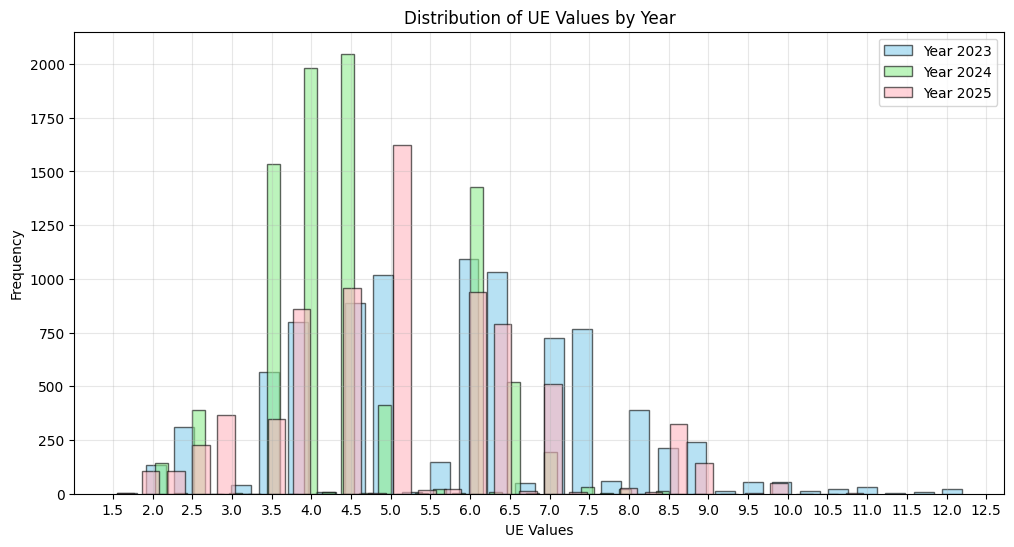

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 6))

colors = [
    (135/255, 206/255, 235/255, 0.6),  # soft blue
    (144/255, 238/255, 144/255, 0.6),  # soft green
    (255/255, 182/255, 193/255, 0.6),  # soft pink
]

# Obtener rango del eje X
xmin = df_UE['UE'].min()
xmax = df_UE['UE'].max()

for year, color in zip(sorted(df_UE['year'].unique()), colors):
    year_data = df_UE[df_UE['year'] == year]['UE']
    plt.hist(
        year_data,
        bins=30,
        alpha=0.6,
        label=f'Year {year}',
        color=color,
        edgecolor='black',
        rwidth=0.7  # <<< barras más delgadas
    )

# Configurar ticks de 0.5 en el eje X
plt.xticks(np.arange(round(xmin, 1), round(xmax + 0.5, 1), 0.5))

plt.title('Distribution of UE Values by Year')
plt.xlabel('UE Values')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



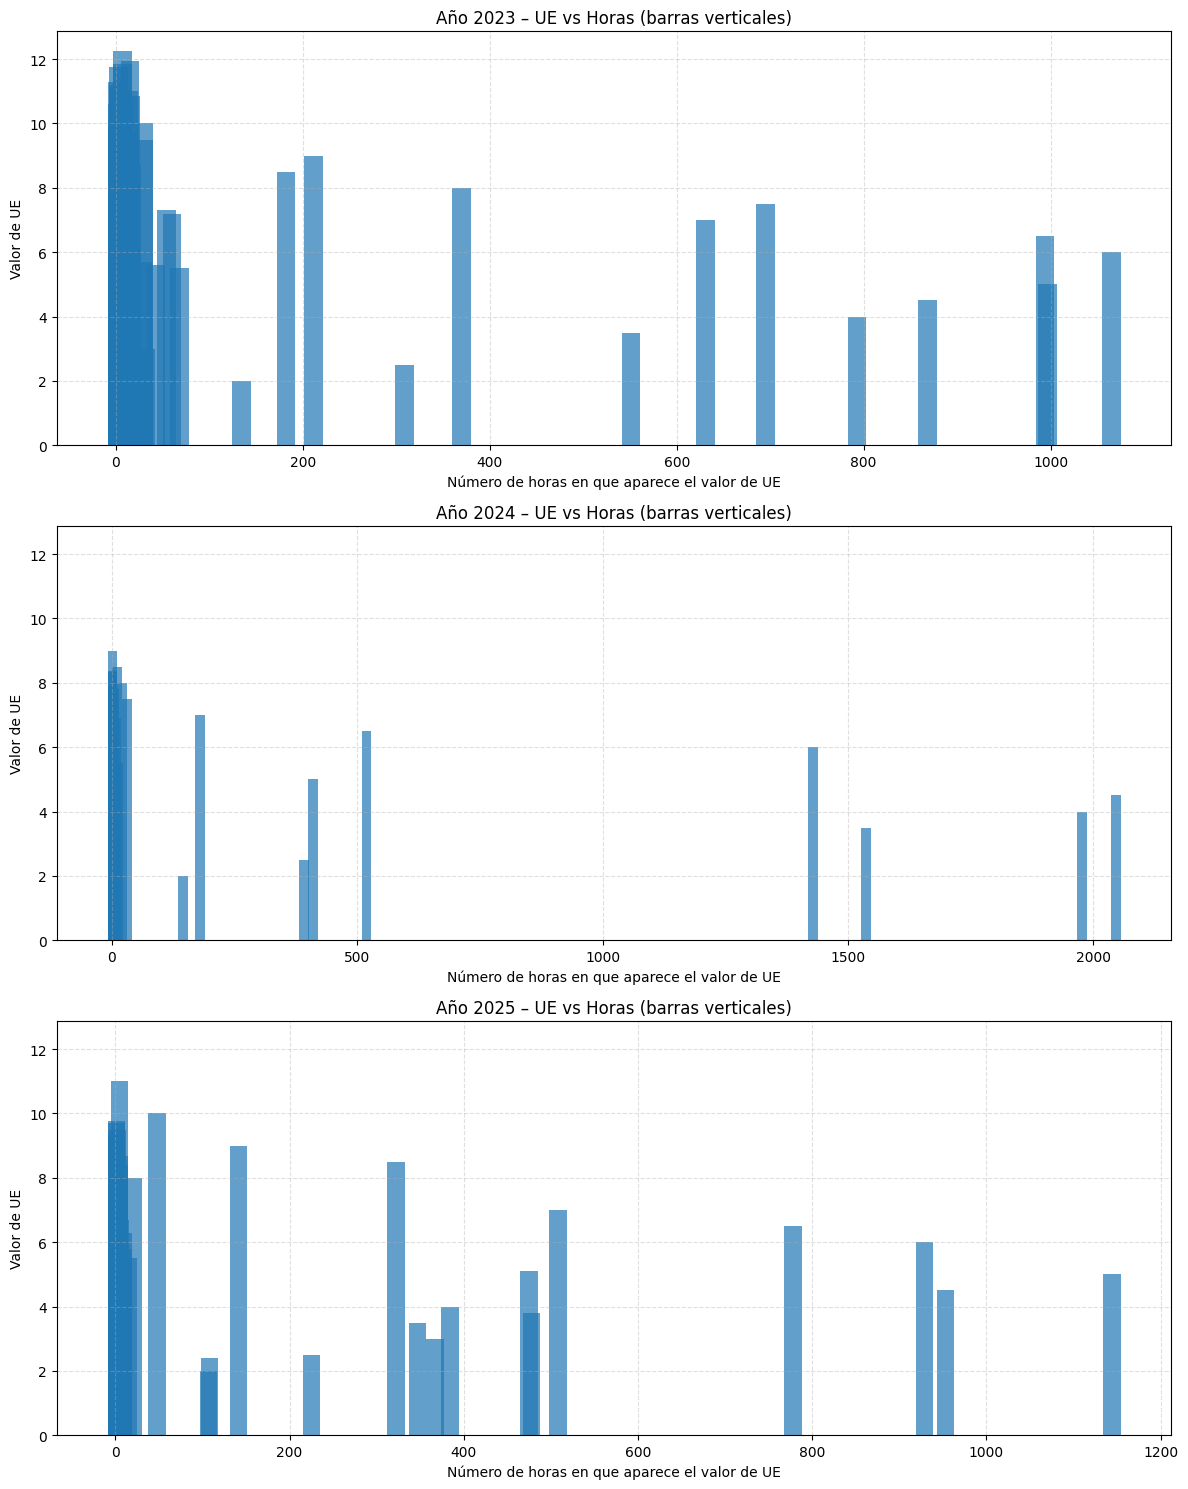

In [14]:
# =====================================================
# 1. Copia del dataframe
# =====================================================
df_UE_copy = df_UE.copy()

df_UE_copy['fechaoperacion'] = pd.to_datetime(df_UE_copy['fechaoperacion'])
df_UE_copy['year'] = df_UE_copy['fechaoperacion'].dt.year

# =====================================================
# 2. Contar cuántas horas aparece cada valor UE por año
# =====================================================
df_counts = (
    df_UE_copy.groupby(['year', 'UE'])
              .size()
              .reset_index(name='horas')
)


# =====================================================
# 3. Gráfico de barras VERTICALES (X = horas, Y = UE) por año
# =====================================================
import matplotlib.pyplot as plt

years = sorted(df_counts['year'].unique())

fig, axes = plt.subplots(len(years), 1, figsize=(12, 5*len(years)), sharey=True)

if len(years) == 1:
    axes = [axes]

for ax, yr in zip(axes, years):
    df_plot = df_counts[df_counts['year'] == yr].sort_values("horas")

    ax.bar(df_plot['horas'], df_plot['UE'], width=20, alpha=0.7)
    ax.set_title(f"Año {yr} – UE vs Horas (barras verticales)")
    ax.set_xlabel("Número de horas en que aparece el valor de UE")
    ax.set_ylabel("Valor de UE")
    ax.grid(True, linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()

